In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import cloupy as cl


C:\Users\stefb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
dijon_communes = gpd.read_file('data\Copy of dijon_communes.geojson')
dijon_quartiers = gpd.read_file('data\Copy of dijon_quartiers.geojson')
LandCoverData = gpd.read_file('data\Copy of LandCoverData.geojson')
SensorLocations = gpd.read_file('data\Copy of SensorLocations_20220316.geojson')


print(dijon_communes.crs)
print(dijon_quartiers.crs)
print(LandCoverData.crs)
print(SensorLocations.crs)


epsg:4326
epsg:4326
epsg:4326
epsg:4326


In [3]:
dbfile='data\Copy of sensorSQLite20220530.db'

con = sqlite3.connect(dbfile)

#Now in order to read in pandas dataframe we need to know table name
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

#device = pd.read_sql_query(SQL_QUERY, con)
device=pd.read_sql_query('SELECT * FROM device', con)
sensorReadings= pd.read_sql_query('SELECT * FROM sensorReadings', con)
measurement=pd.read_sql_query('SELECT * FROM measurement', con)
only_data= pd.read_sql_query('SELECT  fid_measurement, oid, Device_ID,	CO2_concentration_value, CO2_concentration_unit, timestamp_UTC FROM sensorReadings', con)

con.close()


Table Name : [('device',), ('sensorReadings',), ('measurement',)]


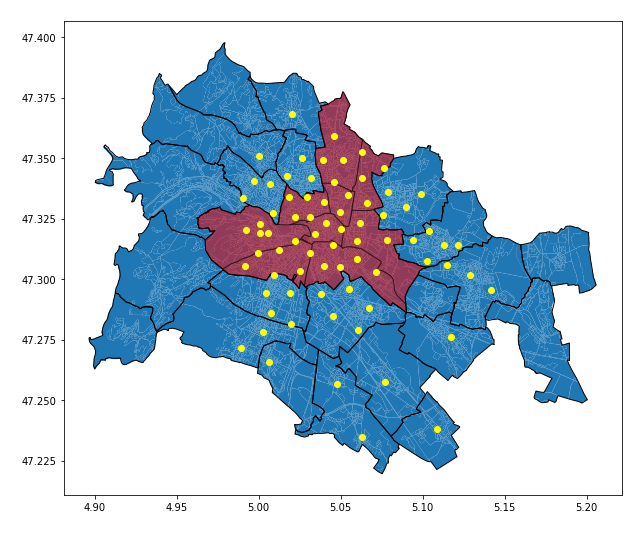

In [4]:
base = LandCoverData.plot(figsize=(10,10))
comm = dijon_communes.plot(ax=base, color='none', edgecolor='black')
quar = dijon_quartiers.plot(ax=comm, color='red', edgecolor='black', alpha=0.5)
s = SensorLocations.plot(ax=quar, color='yellow')
plt.savefig('dataset.png')



In [5]:
def drop_missing_coordinates(gdf,column1):
    gdf.dropna(subset=[column1], how='all',inplace=True)
    return gdf

def drop_dup(gdf):
    gdf.drop_duplicates(keep='first',inplace=True)
    return gdf

def spatial_join(gdf,gdf2):
    return gpd.sjoin(gdf, gdf2,predicate="contains")


def stats2(joined_data, merge_on,sel_col):
    
    grouped = joined_data.groupby(merge_on)[[sel_col]].agg(['min','max','mean']) #add other metrics
    df = grouped.reset_index()
    df.columns = [merge_on, sel_col+"_min", sel_col+"_max",sel_col+"_mean"]
    #joined_data.merge(df, on=merge_on, how="outer")
    return df


In [6]:
column=["ID", "INSEE_COM", "INSEE_DEP", "INSEE_REG", "CODE_POST", "NOM", "SIREN_EPCI", "CODE_SIREN"]
data = pd.concat([dijon_communes[column],dijon_quartiers], axis=1)


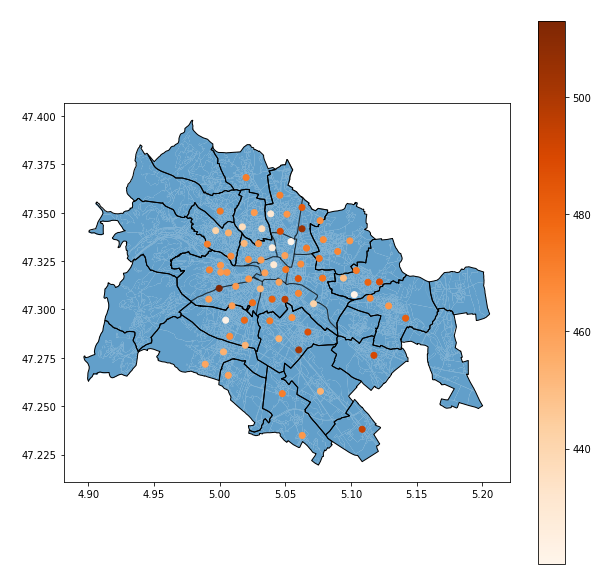

In [7]:
stat = stats2(only_data,'Device_ID','CO2_concentration_value')

SensorLocations['Name'] = SensorLocations['Name'].astype(int)
SensorData = SensorLocations.merge(stat, left_on='Name', right_on='Device_ID')
SensorData = drop_missing_coordinates(SensorData,'geometry')
SensorData = drop_dup(SensorData)


SensorDataTS = SensorLocations.merge(only_data, left_on='Name', right_on='Device_ID')
SensorDataTS = drop_missing_coordinates(SensorDataTS,'geometry')
SensorDataTS = drop_dup(SensorDataTS)


base = LandCoverData.plot(figsize=(10,10),alpha=0.7)
comm = dijon_communes.plot(ax=base, color='none', edgecolor='black')
quar = dijon_quartiers.plot(ax=comm, color='none', edgecolor='black', alpha=0.5)


mappa = SensorData.plot(ax=quar, column='CO2_concentration_value_mean', cmap = "Oranges", legend=True)

plt.savefig('data\mean_value_map.png')



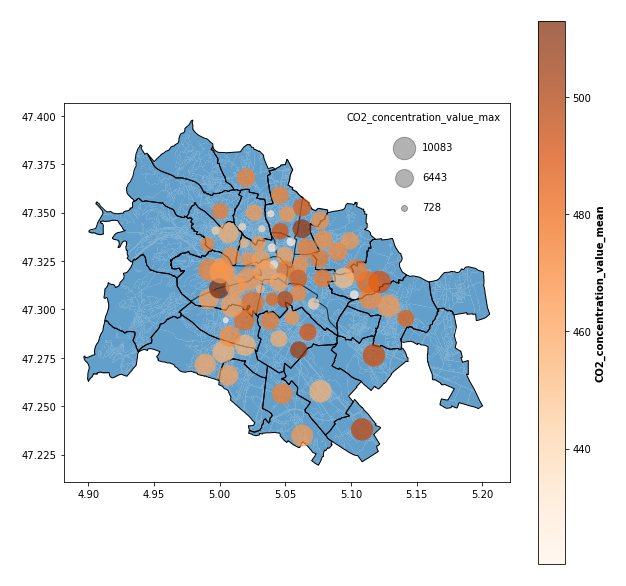

In [8]:
# plot max and avg
base = LandCoverData.plot(figsize=(10,10),alpha=0.7)
comm = dijon_communes.plot(ax=base, color='none', edgecolor='black')
quar = dijon_quartiers.plot(ax=comm, color='none', edgecolor='black', alpha=0.5)

xv = SensorData['xcoord']
yv= SensorData['ycoord']

maxmax=SensorData['CO2_concentration_value_max'].max()
minmin=SensorData['CO2_concentration_value_max'].min()
avgavg=SensorData['CO2_concentration_value_max'].mean()


plt.scatter(xv,yv, label=None,
            c=SensorData['CO2_concentration_value_mean'], cmap='Oranges',
            s=0.05*(SensorData['CO2_concentration_value_max']), linewidth=0, alpha=0.7)


plt.colorbar(label='CO2_concentration_value_mean')

for area in [round(maxmax), round(avgavg), round(minmin)]:
    plt.scatter([], [], c='k', alpha=0.3, s=0.05*area,
                label=str(area))

plt.legend(scatterpoints=1,frameon=False, labelspacing=2, title='CO2_concentration_value_max')

plt.savefig('data\mean&max_value_map.png')

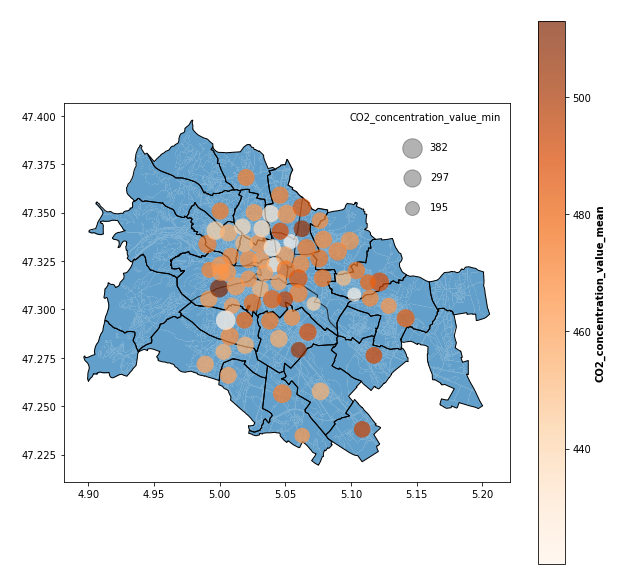

In [9]:
#plot min and avg

base = LandCoverData.plot(figsize=(10,10),alpha=0.7)
comm = dijon_communes.plot(ax=base, color='none', edgecolor='black')
quar = dijon_quartiers.plot(ax=comm, color='none', edgecolor='black', alpha=0.5)

lon = SensorData['xcoord']
lat= SensorData['ycoord']

maxmax=SensorData['CO2_concentration_value_min'].max()
minmin=SensorData['CO2_concentration_value_min'].min()
avgavg=SensorData['CO2_concentration_value_min'].mean()

plt.scatter(lon,lat, label=None,
            c=SensorData['CO2_concentration_value_mean'], cmap='Oranges',
            s=(SensorData['CO2_concentration_value_min']), linewidth=0, alpha=0.7)


plt.colorbar(label='CO2_concentration_value_mean')


for area in [round(maxmax), round(avgavg), round(minmin)]:
    plt.scatter([], [], c='k', alpha=0.3, s=area,
                label=str(area))

plt.legend(scatterpoints=1,frameon=False, labelspacing=2, title='CO2_concentration_value_min')

plt.savefig('data\mean&min_value_map.png')

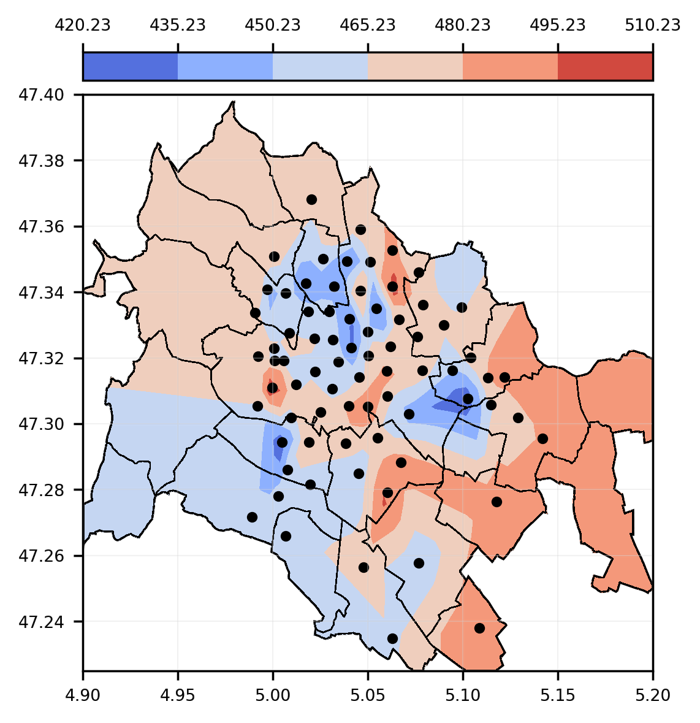

In [31]:

data=SensorData.loc[:,['CO2_concentration_value_mean','xcoord','ycoord']]
data = data.astype('float64')
dijon_communes.to_file('lanCovershape.shp')


imap = cl.m_MapInterpolation(
    shapefile_path='lanCovershape.shp', 
    crs='epsg:4326', 
    dataframe=data
)
imap.draw(
    levels=np.arange(SensorData['CO2_concentration_value_mean'].min(),SensorData['CO2_concentration_value_mean'].max(), 15),
    cmap='coolwarm',
    zoom_in=[(4.90,5.20),(47.225,47.400)],
    interpolation_method='linear',
    interpolation_within_levels=True, 
    boundaries_lw=0.4,
    show_points=True,
    show_grid=True,
    save='heatmap.png'

)



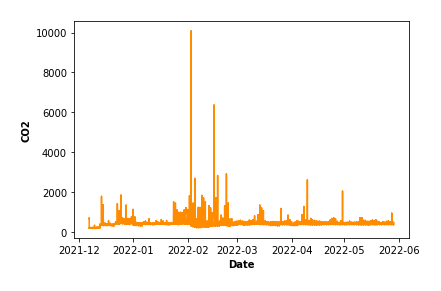

In [11]:

data = SensorDataTS[['CO2_concentration_value','timestamp_UTC']]

grouped = data.groupby('timestamp_UTC').agg(['mean']) #add other metrics
df = grouped.reset_index()
df.columns = ['timestamp_UTC','CO2_concentration_value_mean']
data=df.merge(data, on='timestamp_UTC', how="outer")

data['timestamp_UTC']=round(data['timestamp_UTC']).astype(int)
dates=pd.to_datetime(data['timestamp_UTC'],utc=True,unit='s')

year_month=np.array(dates).astype('str')
date = []
for ym in year_month:

    date.append(ym[:10])

data['date']=date
data['date']=pd.to_datetime(data['date'])


plt.plot(data.date,data.CO2_concentration_value_mean,label='Data',color='darkorange')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.savefig('timeseries.png')


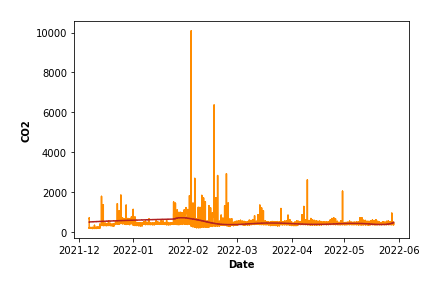

In [12]:
X = np.array(data.index.tolist())
y = np.array(data.CO2_concentration_value_mean)
model = np.poly1d(np.polyfit(X, y, 7))

plt.plot(data.date,data.CO2_concentration_value_mean,label='Data',color='darkorange')
plt.plot(data.date,model(X),label='Model',color='firebrick')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.savefig('timeseriesEst.png')